# Bayesian Deep Learning

With help from: http://www.cs.ox.ac.uk/people/yarin.gal/website/bdl101/.

In [1]:
#%matplotlib widget

from astropy import constants as const
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
import torch
from torch.nn import Linear, Sequential, ReLU, MaxPool1d, Conv1d, Flatten, MSELoss, Module
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from eidein import Eidein
import plot

In [2]:
DEVICE = torch.device("cuda")
DEVICE

device(type='cuda')

In [3]:
with h5py.File("data/dataset.hdf5", "r") as datafile:
    ids = datafile["id_tr"][:]
    ids_va = datafile["id_va"][:]
    X = torch.from_numpy(datafile["X_tr"][:])
    X_va = torch.from_numpy(datafile["X_va"][:])
    y = torch.from_numpy(datafile["z_tr"][:]).float().unsqueeze(dim=-1)
    y_va = torch.from_numpy(datafile["z_va"][:]).float().unsqueeze(dim=-1)

# TODO continuum normalisation

ids.shape, X.size(), y.size()

((440007,), torch.Size([440007, 512]), torch.Size([440007, 1]))

In [4]:
X.dtype, y.dtype

(torch.float32, torch.float32)

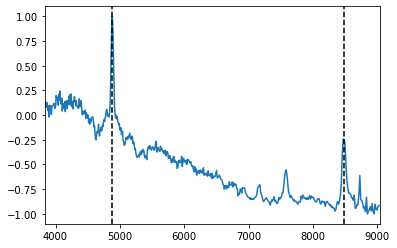

In [5]:
rnd_idx = np.random.randint(X.size(0))
fig, ax = plt.subplots()
plot.spectrum(ax, X[rnd_idx])
plot.redshift(ax, y[rnd_idx, 0])

<AxesSubplot:ylabel='Density'>

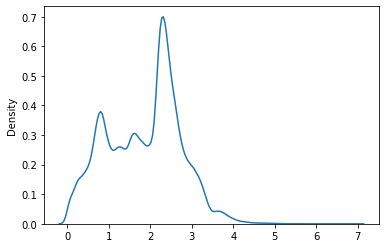

In [6]:
fig, ax = plt.subplots()
sns.kdeplot(y.squeeze(), ax=ax)

In [7]:
def predict(model, X):
    model.eval()
    ds = TensorDataset(X)
    dl = DataLoader(ds, batch_size=1024, shuffle=False)
    with torch.no_grad():
        return torch.cat([model(xb.to(DEVICE)).cpu() for [xb] in dl])


def train(model, X, y, X_va, y_va, epochs, criterion=MSELoss(), weight_decay=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), weight_decay)
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, batch_size=64, shuffle=True)
    losses, losses_va = torch.zeros(epochs), torch.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        for xb, yb in dl:
            optimizer.zero_grad()
            loss = criterion(model(xb.to(DEVICE)), yb.to(DEVICE))
            loss.backward()
            optimizer.step()

        losses[epoch] = criterion(predict(model, X), y)
        losses_va[epoch] = criterion(predict(model, X_va), y_va)

    return losses, losses_va


def plot_losses(losses, losses_va):
    fig, ax = plt.subplots()
    ax.set_xlabel("epoch")
    ax.set_ylabel("MSEloss")
    ax.plot(np.arange(1, epochs + 1), losses, label="validation loss")
    ax.plot(np.arange(1, epochs + 1), losses_va, label="training loss")
    ax.legend()
    return ax


class FreezableWeight(Module):
    def __init__(self):
        super().__init__()
        self.unfreeze()

    def unfreeze(self):
        self.register_buffer("frozen_weight", None)

    def is_frozen(self):
        """Check if a frozen weight is available."""
        return isinstance(self.frozen_weight, torch.Tensor)

    def freeze(self):
        """Sample from the parameter distribution and freeze."""
        raise NonImplementedError()

def freeze(model):
    for layer in model.modules():
        if isinstance(layer, FreezableWeight):
            layer.freeze()
    return model


def unfreeze(model):
    for layer in model.modules():
        if isinstance(layer, FreezableWeight):
            layer.unfreeze()
    return model


def sample_function(model, X, samples=1):
    """Draw realisation of a random function."""
    outputs = torch.zeros(samples, X.size(0), 1)
    for i in range(samples):
        # sample new weights
        freeze(model)
        outputs[i] = predict(model, X)
    unfreeze(model)
    return outputs


class DropoutLinear(Linear, FreezableWeight):
    """Linear layer with dropout on inputs."""
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__(in_features, out_features, bias=bias)
        self.p = p

    def forward(self, input):
        # linear with frozen weight
        if self.is_frozen():
            return F.linear(input, self.frozen_weight, self.bias)
        # stochastic pass as in ActiveDropuout and Linear
        else:
            input = F.dropout(input, self.p, True)
            return F.linear(input, self.weight, self.bias)

    def freeze(self):
        """Apply dropout with rate p to columns of weight and freeze it."""
        with torch.no_grad():
            prob = torch.full_like(self.weight[:1, :], 1 - self.p)
            feature_mask = torch.bernoulli(prob) / prob
            frozen_weight = self.weight * feature_mask
        self.register_buffer("frozen_weight", frozen_weight)

In [8]:
input_dim = X.size(1)
input_dim

512

<AxesSubplot:xlabel='epoch', ylabel='MSEloss'>

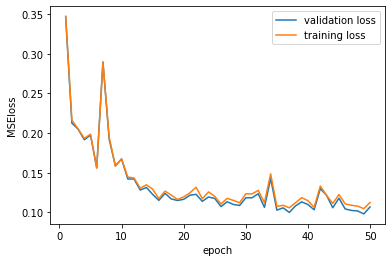

In [9]:
bnn = Sequential(
    Linear(input_dim, 512, bias=True),
    ReLU(),
    DropoutLinear(512, 512, bias=True, p=0.5),
    ReLU(),
    DropoutLinear(512, 1, bias=True, p=0.5)
).to(DEVICE)

epochs = 50
losses, losses_va = train(bnn, X, y, X_va, y_va, epochs)
plot_losses(losses, losses_va)

# TODO https://pytorch.org/tutorials/beginner/saving_loading_models.html
#state_dict_path = "data/bnn.pt"
#torch.save(bnn.state_dict(), state_dict_path)
#bnn.load_state_dict(torch.load(state_dict_path, map_location=DEVICE))

In [10]:
samples = sample_function(bnn, X_va, samples=128)
mean, std = samples.mean(dim=0), samples.std(dim=0)
samples.size()

torch.Size([128, 50000, 1])

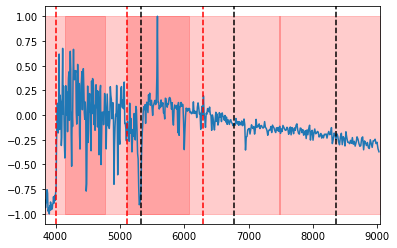

In [11]:
rnd_idx = np.random.randint(X_va.shape[0])
fig, ax = plt.subplots()
plot.spectrum(ax, X_va[rnd_idx])
plot.redshift(ax, y_va[rnd_idx, 0], color="black")
plot.redshift(ax, mean[rnd_idx, 0], std[rnd_idx, 0], color="red")

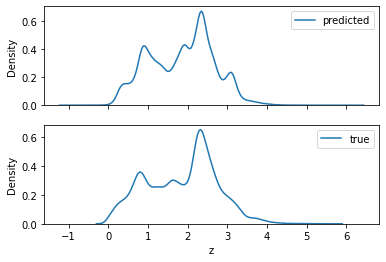

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
sns.kdeplot(mean.squeeze(), ax=ax1, label="predicted")
sns.kdeplot(y_va.squeeze(), ax=ax2, label="true")
ax2.set_xlabel("z")
ax1.legend()
ax2.legend()

Text(0.5, 0, 'delta v (km/s)')

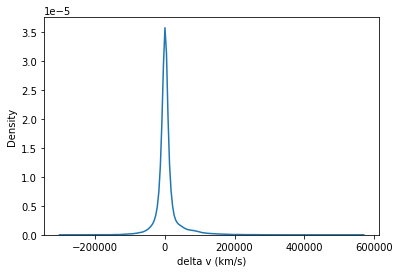

In [13]:
fig, ax = plt.subplots()
delta_v = const.c.to("km/s").value * ((mean - y_va) / (1 + y_va)).squeeze()
sns.kdeplot(delta_v, ax=ax)
ax.set_xlabel("delta v (km/s)")

tensor(2.6067)

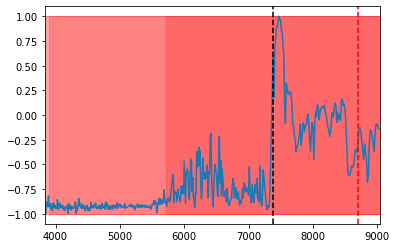

In [14]:
idx = std.argmax()
fig, ax = plt.subplots()
plot.spectrum(ax, X_va[idx])
plot.redshift(ax, y_va[idx, 0], color="black")
plot.redshift(ax, mean[idx, 0], std[idx, 0], color="red")

std.max()

Text(0, 0.5, 'predicted z')

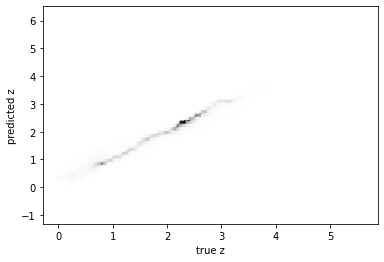

In [15]:
fig, ax = plt.subplots()
ax.hexbin(x=y_va.squeeze(), y=mean.squeeze(), cmap="Greys")
ax.set_xlabel("true z")
ax.set_ylabel("predicted z")

In [ ]:
#Eidein(ids_va, X_va, std)